In [1]:
import os
import glob
import random
import cv2 as cv
import numpy as np
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler

# Feature Extraction

In [ ]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [ ]:
def get_image(annot):
    img_path = "../images/"
    file = annot.split('\\')
    img_filename = img_path + file[-2] + "/" + file[-1] + ".jpg"
    return img_filename

In [ ]:
def image_resizing(dog_images, annotations):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        image = Image.open(dog)
        for j in range(len(bbox)):
            image_2 = image.crop(bbox[j])
            image_2 = image_2.resize((224,224), Image.ANTIALIAS)
            new_path = dog.replace('../images/','../CNN_cropped/')
            new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
            image_2 = image_2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            image_2.save(new_path)

In [ ]:
dog_images = glob.glob("../images/*/*")
annotations = glob.glob("../annotations/*/*")
image_resizing(dog_images, annotations)

In [ ]:
def image_grayscale_conversion():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))

    collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collection[folder] = all_files     
    
    
    # convert image to grayscale   
    grayscaled_images = []    
    for folder, image in collection.items():        
        for img in image:
            path = f"./Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            grayscaled_images.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
    
    
    return grayscaled_images

In [ ]:
def image_normalization():
    class_images = []
    grayscaled_images = image_grayscale_conversion()
    
    for folder in grayscaled_images:
        for images in grayscaled_images[folder]:
            class_images.append(images.ravel())
            
    scaler = MinMaxScaler()
    class_data = scaler.fit_transform(class_images)
    
    return class_data

In [ ]:
def extract_features():
    image_classes = image_normalization()
    
    model = timm.create_model(model_name = 'resnet18', pretrained = True)
    model.fc = nn.Linear(512, 2)
    model.to(device)

^^^THIS PART IS A LOAD OF SHIIIITTT^^^

1. dimension reductions
2. all the clusters
3. all the evaluations

In [53]:
def get_images():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))

    collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collection[folder] = all_files     
    
    return collection

In [54]:
def grayscale_conversion():
    collection = get_images()       
    
    grayscaled_images = {}
    for folder, images in collection.items():
        combine = []
        for img in images:
            path = f"../Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        grayscaled_images[folder] = combine
    
    return grayscaled_images 

In [55]:
def normalized_dataset():
    class_images = []
    grayscaled_images = grayscale_conversion()
    
    for folder in grayscaled_images:
        for images in grayscaled_images[folder]:
            class_images.append(images.ravel())
            
    scaler = MinMaxScaler()
    class_data = scaler.fit_transform(class_images)
    
    return class_data

In [56]:
def dimensionality_reduction():
    transformed_data = []
    class_data = normalized_dataset()
    
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))
    
    len_1 = no_of_images[0]
    len_2 = no_of_images[0] + no_of_images[1]
    len_3 = no_of_images[0] + no_of_images[1] + no_of_images[2]
    len_4 = no_of_images[0] + no_of_images[1] + no_of_images[2] + no_of_images[3]
    
    pca = PCA(n_components = 2) 
    transformed_data = pca.fit_transform(class_data)
    transformed_data_1 = transformed_data[:len_1]
    transformed_data_2 = transformed_data[len_1:len_2]
    transformed_data_3 = transformed_data[len_2:len_3]
    transformed_data_4 = transformed_data[len_3:len_4]
    
    return transformed_data

# Clustering Algorithms

In [57]:
def k_means_clustering(X):
    kmeans = KMeans(n_clusters=4, random_state=0, init="random", n_init="auto").fit(X)
    
    return kmeans

In [58]:
def k_means_plus(X):
    kmeans_plus = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(X)
    
    return kmeans_plus

In [59]:
def bisecting_kmeans(X):
    b_kmeans = BisectingKMeans(n_clusters=4, random_state=0, init="random").fit(X)
    
    return b_kmeans

In [60]:
def spectral_clustering(X):
    s_clustering = SpectralClustering(n_clusters=4).fit(X)
    
    return s_clustering

In [61]:
def dbscan(X):
    dbscan_clustering = DBSCAN(eps=2.1, min_samples=15).fit(X)
    labels = dbscan_clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0) + 1
    print(n_clusters)
    
    return dbscan_clustering

In [62]:
def agglomerative_clustering(X):
    single = AgglomerativeClustering(n_clusters=4, linkage="single").fit(X)
    complete = AgglomerativeClustering(n_clusters=4, linkage="complete").fit(X)
    average = AgglomerativeClustering(n_clusters=4, linkage="average").fit(X)
    ward = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X)
    
    return single, complete, average, ward

In [63]:
X = dimensionality_reduction()

kmeans = k_means_clustering(X)
kmeans_plus = k_means_plus(X)
b_kmeans = bisecting_kmeans(X)
s_clustering = spectral_clustering(X)
dbscan_clustering = dbscan(X)
single_clu, complete_clu, average_clu, ward_clu = agglomerative_clustering(X)
print(dbscan_clustering)

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited at iteration 652 with accuracies 
[5.95891445e-15 1.71392788e-05 6.86880683e-06 6.32038131e-06
 9.41062488e-06]
not reaching the requested tolerance 9.700655937194824e-06.
Use iteration 652 instead with accuracy 
7.947818357677558e-06.

  _, diffusion_map = lobpcg(
C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[2.84650771e-15 1.71394641e-05 6.86834186e-06 6.32039920e-06
 9.41061473e-06]
not reaching the requested tolerance 9.700655937194824e-06.
  _, diffusion_map = lobpcg(
C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, 

4
DBSCAN(eps=2.1, min_samples=15)


In [64]:
def plot_clusters():
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans_plus.labels_)
    plt.scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans++")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=b_kmeans.labels_)
    plt.scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("BisectingKMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=s_clustering.labels_)
    plt.title("SpectralClustering")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=dbscan_clustering.labels_)
    plt.title("DBSCAN")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=single_clu.labels_)
    plt.title("Single Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=complete_clu.labels_)
    plt.title("Complete Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=average_clu.labels_)
    plt.title("Average Agglomerative Linkage")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], c=ward_clu.labels_)
    plt.title("Ward Agglomerative Linkage")
    plt.show()

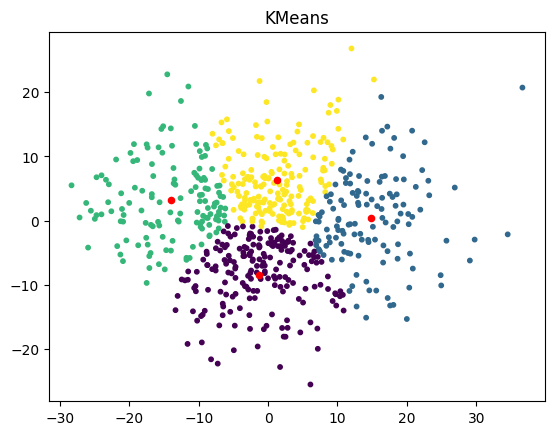

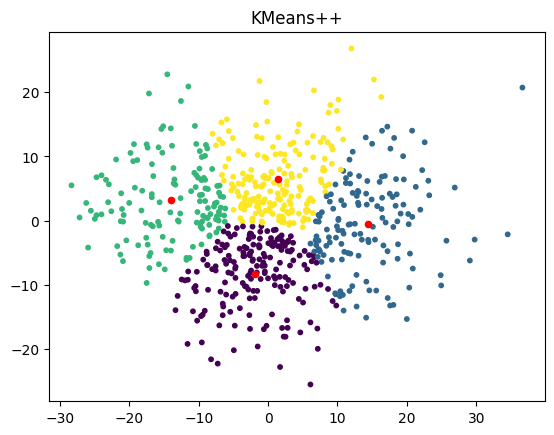

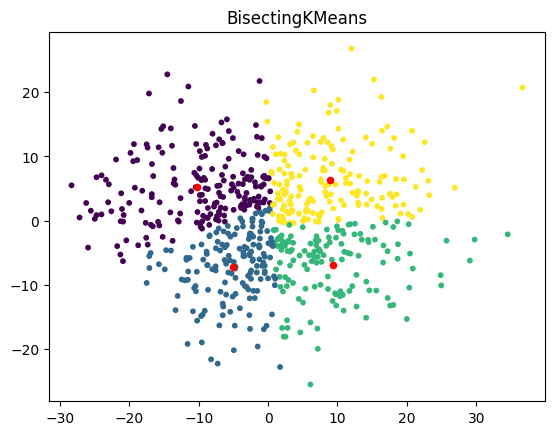

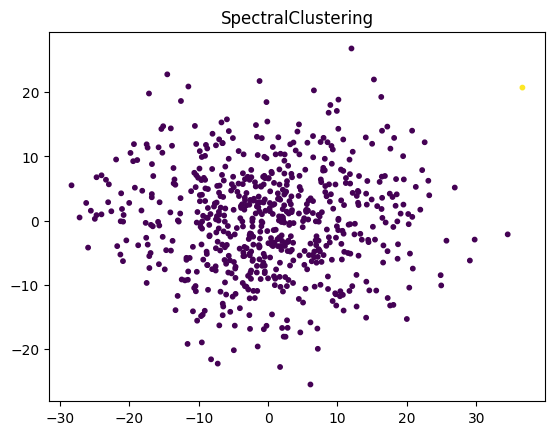

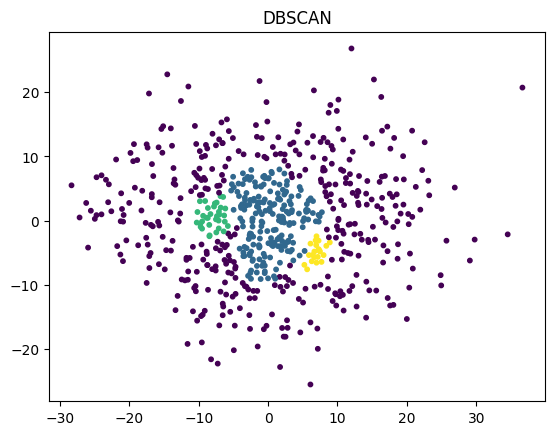

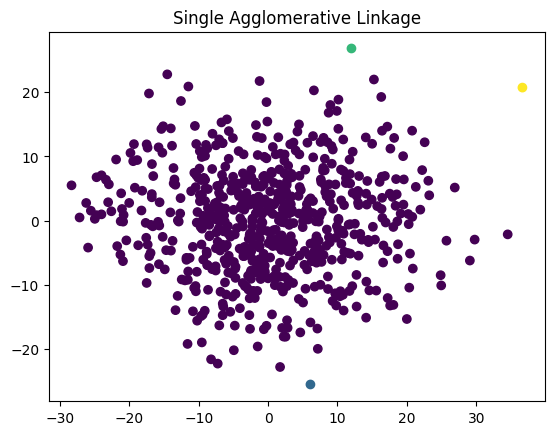

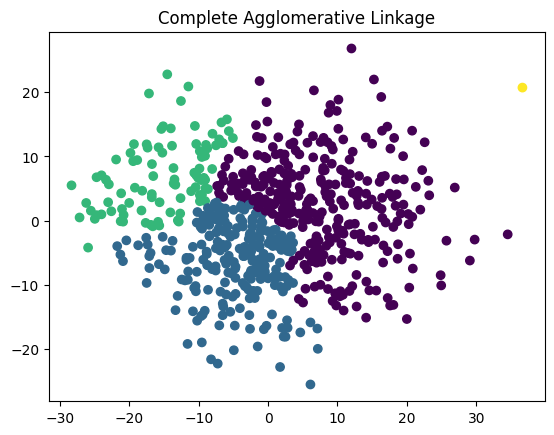

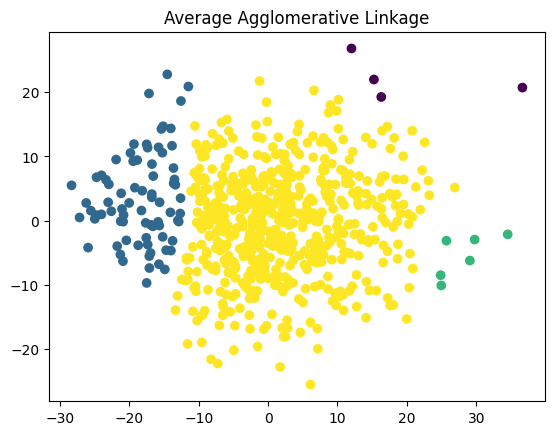

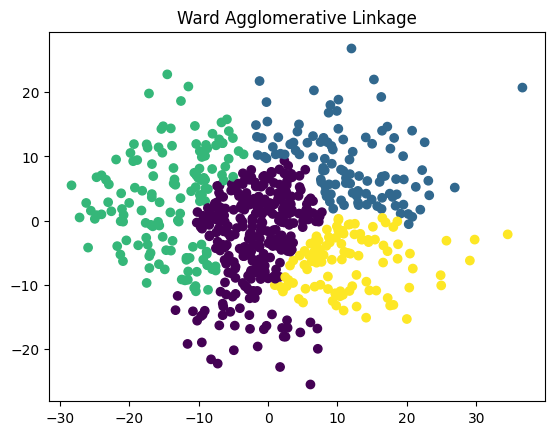

In [65]:
plot_clusters()

# Clustering Evalutions

In [66]:
def fowlkes_mallows_score_evaluation():
    results = []
    clusters = [kmeans, kmeans_plus, b_kmeans, s_clustering, dbscan_clustering, single_clu, complete_clu, average_clu, ward_clu]

    for method in clusters:
        print(type(X))
        print(X)
        results.append(fowlkes_mallows_score(X, method.labels_))

    print(results)
fowlkes_mallows_score_evaluation()

<class 'numpy.ndarray'>
[[ 3.36001275  7.28853866]
 [ 8.17950308  9.63820123]
 [16.35522041  1.82363505]
 ...
 [-2.13052698  3.12377507]
 [10.94932715  2.43110658]
 [-6.16039707  8.41598127]]


ValueError: labels_true must be 1D: shape is (651, 2)

In [75]:
def silhouette_score_evaluation():
    results = []
    clusters = [kmeans, kmeans_plus, b_kmeans, s_clustering, dbscan_clustering, single_clu, complete_clu, average_clu, ward_clu]

    for method in clusters:
        results.append(silhouette_score(X, method.labels_))
    print(results)
    print(f"{clusters[results.index(max(results))]}: {max(results)}") 

In [76]:
silhouette_score_evaluation()

[0.3362245640043559, 0.33577962812869294, 0.28826569937298907, 0.5802488353288626, -0.20147896414659786, 0.2573665988579322, 0.28816985150217184, 0.23255659943008203, 0.27473908818733295]
SpectralClustering(n_clusters=4): 0.5802488353288626
